## Executive Summary

This project demonstrates how predictive models must be evaluated in alignment with policy objectives and healthcare capacity constraints. Thus, it analyzes COVID-19 patient-level data to identify factors associated with urgent
hospitalization outcomes. Using exploratory analysis and supervised learning models, the study
finds that age and symptom combinations play a key role in urgency classification, with non-linear
models outperforming linear baselines.


# COVID-19 Comparative Data Analysis

Capstone project for HarvardX CS109x Introduction to Data Science with Python.

## Objective
Analyze COVID-19 trends across three countries with different demographic and health characteristics,
and evaluate factors associated with urgent medical outcomes.

## 1. Indtroduction
The goal is to predict the urgency with which a COVID-19 patient will need to be admitted to the hospital from the time of onset of symptoms. The dataset contains some COVID-19 symptoms and demographic information.   
Primary predictors: age, sex, cough, fever, chills, sore throat, headache, fatigue. For each: 1 if have symptom, 0 if no symptom 

Response variable:  Urgency of admission where 
1 => High Urgency which means the patient was admitted within 1 day from the onset of symptoms
0 => No Urgency - everyone else 

## 2. Data Cleaning and Preparation

In this section, missing values are identified and imputed using the K-Nearest Neighbors (KNN) method.
Only numeric variables are included in the imputation process.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
%matplotlib inline


## 3. Data Source

The dataset contains anonymized patient-level COVID-19 records, including demographic
information (such as age), reported symptoms, and a binary urgency classification indicating
whether hospitalization was urgent or non-urgent. The data is used to explore patterns associated
with severe outcomes and to evaluate predictive modeling approaches.

In [2]:
# Read the datafile "covid.csv"
df = pd.read_csv("covid.csv")

# dataframe
df.head()

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,Urgency
0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,49.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,59.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [3]:
# Missing or Null values
df.isnull().sum()

age             6
sex             8
cough          11
fever          15
chills          4
sore_throat     6
headache        2
fatigue         4
Urgency         0
dtype: int64

In [4]:
# Number of rows with missing values
num_null = df.isnull().any(axis=1).sum()
print("Number of rows with null values:", num_null)  

Number of rows with null values: 37


### 4. Handling Missing Values

Missing numerical values were imputed using the K-Nearest Neighbors (KNN) algorithm with k = 5.
The target variable (`Urgency`) was excluded from the imputation process to prevent data leakage.


In [5]:
# kNN impute the missing data
# K value of 5
imputer = KNNImputer(n_neighbors=5)

# Separate predictors and response (Urgency is the response variable)
X = df.drop("Urgency", axis=1)
y = df["Urgency"]

# Fit imputer on predictors and transform
X_imputed = imputer.fit_transform(X)

# Put back into a DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=X.columns, index=df.index)

# Combine back with the response
df_imputed = pd.concat([X_imputed, y], axis=1)

In [6]:
# Replace the original dataframe with the imputed data
df = df_imputed.copy()
    

## 5. Exploratory Data Analysis

This section explores the relationship between age, symptoms, and urgency outcomes.


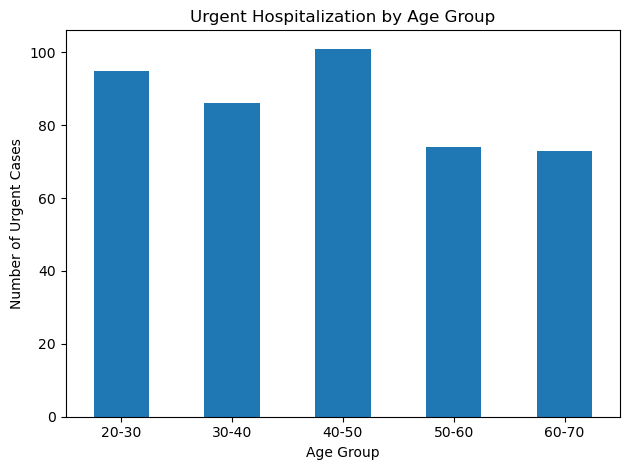

In [7]:
## EDA

bins = [20, 30, 40, 50, 60, 70]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)
# Filter only urgent cases
urgent_cases = df[df['Urgency'] == 1]
# Count urgent cases by age group
age_urgency = urgent_cases['age_group'].value_counts().sort_index()
# Plot the results
age_urgency.plot(kind='bar')
plt.title("Urgent Hospitalization by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Urgent Cases")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Urgent Hospitalization by Age Group

The bar chart shows the distribution of urgent hospitalization cases across different age groups.
The highest number of urgent cases is observed among individuals aged 40–50, followed by the 20–30
and 30–40 age groups. In contrast, older age groups (50–60 and 60–70) exhibit a lower number of urgent
hospitalizations in this dataset.

This pattern suggests that urgent COVID-19 outcomes are not exclusively concentrated among the oldest
patients, but also significantly affect middle-aged individuals. These results highlight the importance
of considering age heterogeneity when assessing health risks and allocating medical resources.


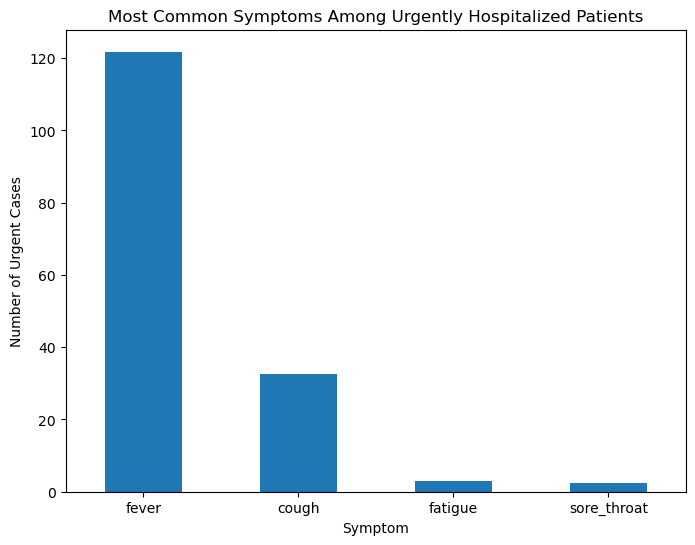

In [8]:
# Filter for patients with Urgency == 1
urgent_patients = df[df['Urgency'] == 1]

# List of symptoms to check
symptoms = ['cough', 'fever', 'sore_throat', 'fatigue']

# Count how many patients with each symptom
symptom_counts = urgent_patients[symptoms].sum()

# Plot
plt.figure(figsize=(8, 6))
symptom_counts.sort_values(ascending=False).plot(kind='bar')
plt.title('Most Common Symptoms Among Urgently Hospitalized Patients')
plt.ylabel('Number of Urgent Cases')
plt.xlabel('Symptom')
plt.xticks(rotation=0)
plt.show()

### Most Common Symptoms Among Urgently Hospitalized Patients

This figure presents the frequency of reported symptoms among patients classified as urgent cases.
Fever is by far the most common symptom, followed by cough, while fatigue and sore throat appear
much less frequently among urgent hospitalizations.

The dominance of fever and cough suggests that these symptoms are strong indicators of severe
disease progression in this dataset. This finding is consistent with clinical observations that
respiratory and systemic symptoms are closely associated with adverse COVID-19 outcomes.


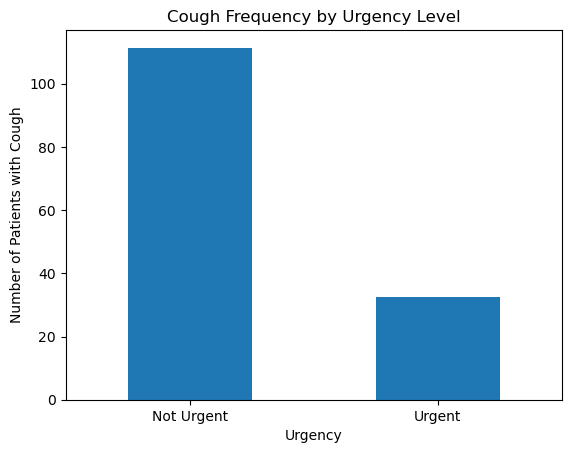

In [9]:
 # Group by 'Urgency' and calculate the sum of 'cough' cases for each group
cough_counts = df.groupby('Urgency')['cough'].sum()

# Plotting
cough_counts.plot(kind='bar')
plt.xticks([0, 1], ['Not Urgent', 'Urgent'], rotation=0)
plt.ylabel('Number of Patients with Cough')
plt.title('Cough Frequency by Urgency Level')
plt.show()

### Cough Frequency by Urgency Level

The chart compares the number of patients presenting cough symptoms across urgency classifications.
Patients categorized as “Not Urgent” report cough more frequently in absolute terms than those in
the “Urgent” group.

This result suggests that cough alone may not be a sufficient predictor of urgent medical outcomes.
Instead, urgency is likely driven by a combination of symptoms, demographic factors, and underlying
health conditions. This finding reinforces the need for multivariate analysis when assessing patient
risk rather than relying on individual symptoms in isolation.


## 6. Predictive Modeling

To further assess the relationship between patient characteristics and urgent hospitalization,
supervised classification models are applied. Logistic Regression and K-Nearest Neighbors (KNN)
are used to compare linear and non-linear modeling approaches.

In [10]:
### Train Test Split

from sklearn.model_selection import train_test_split

if 'age_group' in df.columns:
    df = df.drop(columns=['age_group'])  # to avoid issues with strings like '30-40'
df_train, df_test = train_test_split(df, train_size=0.7, random_state=60)

# Save the train data 
df_train.to_csv("covid_train.csv", index=False)
# Save the test data 
df_test.to_csv("covid_test.csv", index=False)


In [11]:
# Read"covid_train.csv"
train_df = pd.read_csv("covid_train.csv")

print(train_df.head())
print(train_df.info())

    age  sex  cough  fever  chills  sore_throat  headache  fatigue  Urgency
0  37.0  1.0    0.0    1.0     0.0          1.0       0.0      0.0        0
1  35.0  0.0    0.0    0.0     0.0          0.0       1.0      0.0        0
2  39.0  1.0    0.0    0.0     0.0          0.0       0.0      0.0        1
3  48.0  1.0    0.0    0.0     0.0          0.0       0.0      0.0        0
4  40.0  1.0    0.0    1.0     0.0          0.0       0.0      0.0        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          700 non-null    float64
 1   sex          700 non-null    float64
 2   cough        700 non-null    float64
 3   fever        700 non-null    float64
 4   chills       700 non-null    float64
 5   sore_throat  700 non-null    float64
 6   headache     700 non-null    float64
 7   fatigue      700 non-null    float64
 8   Urgency      70

In [12]:
# Read "covid_test.csv"
test_df = pd.read_csv("covid_test.csv")

print(test_df.head())
print(test_df.info())

    age  sex  cough  fever  chills  sore_throat  headache  fatigue  Urgency
0  40.0  1.0    0.0    1.0     0.0          0.0       0.0      0.0        0
1  42.0  0.0    0.0    0.0     0.0          0.0       0.0      0.0        1
2  53.0  0.0    0.0    0.0     0.0          0.0       0.0      0.0        0
3  20.0  0.0    0.0    1.0     0.0          0.0       0.0      0.0        0
4  29.0  1.0    0.0    0.0     0.0          0.0       0.0      0.0        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          301 non-null    float64
 1   sex          301 non-null    float64
 2   cough        301 non-null    float64
 3   fever        301 non-null    float64
 4   chills       301 non-null    float64
 5   sore_throat  301 non-null    float64
 6   headache     301 non-null    float64
 7   fatigue      301 non-null    float64
 8   Urgency      30

In [13]:
# Get the train predictors
X_train = train_df.drop(columns=['Urgency'])

# Get the train response variable
y_train = train_df['Urgency']

# Get the test predictors
X_test = test_df.drop(columns=['Urgency'])

# Get the test response variable
y_test = test_df['Urgency']

# Define your classification model
model = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the train data
model.fit(X_train, y_train)

KNeighborsClassifier()

In [14]:
# Predict and compute the accuracy on the test data
y_pred = model.predict(X_test)

model_accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy is {model_accuracy}")

Model Accuracy is 0.6677740863787376


In [15]:
# KNN classification model with k = 7
knn_model = KNeighborsClassifier(n_neighbors=7)
# Model on the train data
knn_model.fit(X_train, y_train)
# Logistic Regression model with max_iter as 10000 and C as 0.1
log_model = LogisticRegression(max_iter=10000, C=0.1)
# Logistic Regression model on the train data
log_model.fit(X_train, y_train)

# Predict with both models
knn_preds = knn_model.predict(X_test)
log_preds = log_model.predict(X_test)

# Compute confusion matrices
knn_cm = confusion_matrix(y_test, knn_preds)
log_cm = confusion_matrix(y_test, log_preds)

# Specificity = TN / (TN + FP)
def compute_specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

# Calculate all metrics
metric_scores = {
    "Accuracy": [accuracy_score(y_test, knn_preds), accuracy_score(y_test, log_preds)],
    "Recall": [recall_score(y_test, knn_preds), recall_score(y_test, log_preds)],
    "Specificity": [compute_specificity(knn_cm), compute_specificity(log_cm)],
    "Precision": [precision_score(y_test, knn_preds), precision_score(y_test, log_preds)],
    "F1-score": [f1_score(y_test, knn_preds), f1_score(y_test, log_preds)]
}

# Display results
print(metric_scores)

{'Accuracy': [0.6843853820598007, 0.6079734219269103], 'Recall': [0.7872340425531915, 0.7163120567375887], 'Specificity': [np.float64(0.59375), np.float64(0.5125)], 'Precision': [0.6306818181818182, 0.5642458100558659], 'F1-score': [0.7003154574132492, 0.63125]}


In [16]:
# KNN classification model with k = 7
knn = KNeighborsClassifier(n_neighbors=7)

# Model on the train data
knn.fit(X_train, y_train)
# Probabilities for the positive class on the test data using the kNN model
y_pred_knn = knn.predict_proba(X_test)[:, 1]

In [17]:
# Define a Logistic Regression model with max_iter as 10000, C as 0.1, and a random_state of 42
logreg = LogisticRegression(max_iter=10000, C=0.1, random_state=42)

# Logistic Regression model on the train data
logreg.fit(X_train, y_train)

# Probabilities for the positive class on the test data using the logistic regression model
y_pred_logreg = logreg.predict_proba(X_test)[:, 1]

In [18]:
def get_thresholds(y_pred_proba):
    # We only need to consider unique predicted probabilities
    unique_probas = np.unique(y_pred_proba)
    # Sort unique probabilities in descending order
    unique_probas_sorted = np.sort(unique_probas)[::-1]
    # We'll also add some additional thresholds to our set
    # This ensures our ROC curves reach the corners of the plot, (0,0) and (1,1)
    # Insert 1.1 at the beginning of the threshold array
    # 1.1 may seem like an odd threshold, but a value greater than 1
    # is required if we want the ROC curve to reach the lower left corner
    # (0 fpr, 0 tpr) considering one of our models produces probability predictions of 1
    thresholds = np.insert(unique_probas_sorted, 0, 1.1)
    # Append 0 to the end of the thresholds
    thresholds = np.append(thresholds, 0)
    return thresholds

In [19]:
### thresholds 

knn_thresholds = get_thresholds(y_pred_knn)

logreg_thresholds = get_thresholds(y_pred_logreg)

In [20]:
### fpr 
def get_fpr(y_true, y_pred_proba, threshold): 
    y_pred = (y_pred_proba >= threshold).astype(int)
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    TN = ((y_pred == 0) & (y_true == 0)).sum()
    return FP / (FP + TN) if (FP + TN) != 0 else 0
    
### tpr 

def get_tpr(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()
    return TP / (TP + FN) if (TP + FN) != 0 else 0

In [21]:
knn_thresholds = get_thresholds(y_pred_knn)
logreg_thresholds = get_thresholds(y_pred_logreg)
# FPR for the kNN at each of its thresholds
knn_fpr = [get_fpr(y_test, y_pred_knn, th) for th in knn_thresholds]
# TPR for the kNN at each of its thresholds
knn_tpr = [get_tpr(y_test, y_pred_knn, th) for th in knn_thresholds]

# TPR for the logistic model at each of its thresholds
logreg_tpr = [get_tpr(y_test, y_pred_logreg, th) for th in logreg_thresholds]
# FPR for the logistic model at each of its thresholds
logreg_fpr = [get_fpr(y_test, y_pred_logreg, th) for th in logreg_thresholds]

In [22]:
# ROC AUC score of the Logistic model
knn_auc = roc_auc_score(y_test, y_pred_knn)

# ROC AUC score of the kNN model
logreg_auc = roc_auc_score(y_test, y_pred_logreg)

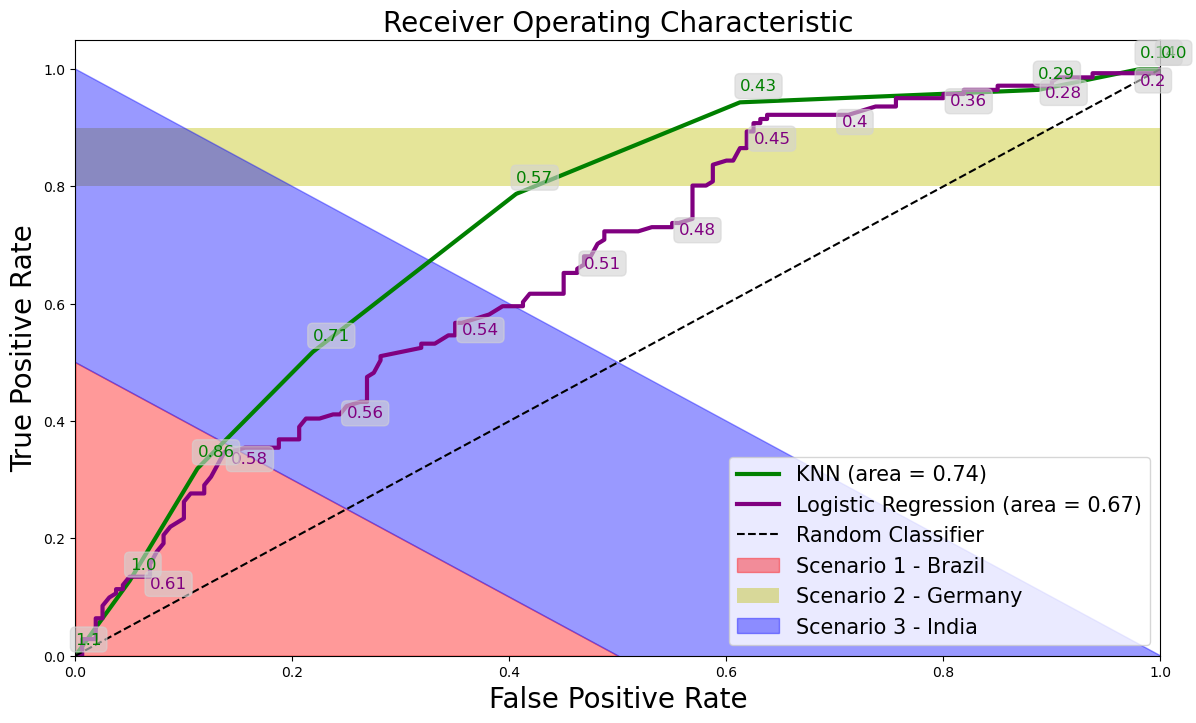

In [23]:
# Area under curve - Logistic Regression & kNN
fig, ax = plt.subplots(figsize = (14,8))
# Plot KNN Regression ROC Curve
ax.plot(knn_fpr,
        knn_tpr,
        label=f'KNN (area = {knn_auc:.2f})',
        color='g',
        lw=3)
# Plot Logistic Regression ROC Curve
ax.plot(logreg_fpr,
        logreg_tpr,
        label=f'Logistic Regression (area = {logreg_auc:.2f})',
        color = 'purple',
        lw=3)
# Threshold annotations
label_kwargs = {}
label_kwargs['bbox'] = dict(
    boxstyle='round, pad=0.3', color='lightgray', alpha=0.6
)
eps = 0.02 # offset
for i in range(0, len(logreg_fpr),15):
    threshold = str(np.round(logreg_thresholds[i], 2))
    ax.annotate(threshold, (logreg_fpr[i], logreg_tpr[i]-eps), fontsize=12, color='purple', **label_kwargs)

for i in range(0, len(knn_fpr)-1):
    threshold = str(np.round(knn_thresholds[i], 2))
    ax.annotate(threshold, (knn_fpr[i], knn_tpr[i]+eps), fontsize=12, color='green', **label_kwargs)

# Plot diagonal line representing a random classifier
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Scenario 1 - Brazil
ax.fill_between([0,0.5],[0.5,0], color = 'red', alpha = 0.4, label='Scenario 1 - Brazil');

# Scenario 2 - Germany
ax.axhspan(0.8, 0.9, facecolor='y', alpha=0.4, label = 'Scenario 2 - Germany');

# Scenario 3 - India
ax.fill_between([0,1],[1,0],[0.5,-0.5], alpha = 0.4, color = 'blue', label = 'Scenario 3 - India');

ax.set_xlim([0.0, 1.0]);
ax.set_ylim([0.0, 1.05]);
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title('Receiver Operating Characteristic', fontsize=20)
ax.legend(loc="lower right", fontsize=15)
plt.show()

## (ROC) Curve Analysis

The Receiver Operating Characteristic (ROC) curve illustrates the trade-off between the True
Positive Rate (TPR) and the False Positive Rate (FPR) across different classification thresholds
for identifying urgent COVID-19 cases. The dashed diagonal line represents random classification,
serving as a baseline for comparison.

Two models are evaluated: Logistic Regression and K-Nearest Neighbors (KNN). The KNN model achieves
a higher Area Under the Curve (AUC = 0.74) compared to Logistic Regression (AUC = 0.67), indicating
a stronger overall capacity to distinguish urgent from non-urgent cases. This suggests that
non-linear interactions among patient characteristics play an important role in urgency prediction.

Beyond aggregate performance, the shaded regions highlight three policy-driven scenarios that
impose distinct operational constraints on model selection. In the Brazil scenario (red region),
the objective is to minimize public alarm by limiting both true and false positive classifications.
This requires operating at conservative thresholds where the combined TPR and FPR remain low,
favoring specificity over sensitivity.

In contrast, the Germany scenario (yellow region) prioritizes patient survival by maximizing the
identification of urgent cases. This scenario emphasizes high sensitivity, accepting a higher
false positive rate to ensure that critical patients are not missed. As a result, model thresholds
must operate in regions of the ROC curve with elevated TPR values.

The India scenario (blue region) reflects severe resource constraints, where hospital capacity is
limited relative to the number of suspected cases. Here, the objective is to balance sensitivity
and specificity to avoid overwhelming healthcare systems while still identifying those in greatest
need of urgent care.

Taken together, the ROC analysis demonstrates that no single classifier or threshold is universally
optimal. Instead, model evaluation and deployment must be aligned with policy objectives, healthcare
capacity, and the relative costs of classification errors. While KNN shows superior overall
discriminatory power, the final model choice depends on the specific operational context in which
it is applied.


## 7. Policy-Oriented Scenario Analysis

### Scenario 1 – Brazil: Minimizing Public Alarm

In this scenario, the policy objective prioritizes limiting the number of individuals classified
as high risk in order to avoid public panic and political backlash. From a modeling perspective,
this implies strict control over false positives, even at the cost of missing some urgent cases.

To reflect this constraint, the model selection focuses on operating points where the combined
true positive rate (TPR) and false positive rate (FPR) remain low:

TPR + FPR ≤ 0.5

Under this constraint, the preferred classifier is one that maintains conservative predictions,
favoring specificity over sensitivity.

### Scenario 2 – Germany: Maximizing Survival Outcomes

In this scenario, the primary objective is to minimize fatal outcomes by identifying as many
urgent cases as possible. Missing an urgent patient is considered substantially more costly
than incorrectly flagging a non-urgent case.

As a result, the model must achieve a high true positive rate, reflecting strong sensitivity:

0.8 ≤ TPR ≤ 0.9

This constraint favors classifiers that prioritize recall, even if it leads to a higher false
positive rate. Such an approach is appropriate in healthcare systems where resources are sufficient
to absorb over-triage in exchange for improved patient survival.


### Scenario 3 – India: Resource-Constrained Triage

This scenario reflects a severe capacity constraint, where the number of suspected cases exceeds
available hospital resources. The policy challenge is to identify the most urgent patients while
avoiding overwhelming the healthcare system.

The corresponding modeling constraint balances sensitivity and specificity:

TPR + FPR ≤ 1

This condition represents a compromise between detecting urgent cases and controlling unnecessary
admissions. It emphasizes the importance of threshold selection in resource-limited environments,
where both types of classification errors carry significant consequences.



## 8. Conclusions and Limitations

This project analyzed patient-level COVID-19 data to identify factors associated with urgent
hospitalization outcomes using exploratory data analysis and supervised machine learning models.
The results show that demographic characteristics, particularly age, and symptom combinations
play an important role in distinguishing between urgent and non-urgent cases.

Exploratory analysis revealed that urgent hospitalizations are not limited to the oldest age
groups, highlighting the relevance of middle-aged populations in severe outcomes. Fever and
cough emerged as the most common symptoms among urgent cases, although symptom presence alone
was insufficient to fully explain urgency, reinforcing the need for multivariate analysis.

In the predictive modeling stage, both Logistic Regression and K-Nearest Neighbors (KNN)
demonstrated performance above random classification. The KNN model achieved a higher AUC,
suggesting that non-linear relationships among patient features contribute meaningfully to
urgency classification. However, model performance varied depending on the selected operating
threshold.

The policy-oriented scenario analysis emphasized that model evaluation should be context-dependent.
Different healthcare and policy objectives require different trade-offs between sensitivity and
specificity. As illustrated by the Brazil, Germany, and India scenarios, the optimal classifier
and threshold depend not only on predictive accuracy but also on resource constraints, public
health priorities, and the relative cost of classification errors.

### Limitations and Future Work

This analysis is subject to several limitations. The dataset size and scope may limit
generalizability, and the urgency classification may be influenced by unobserved clinical
variables. Model evaluation relied on a single train-test split, which may not fully capture
performance variability.

Future work could incorporate cross-validation, additional performance metrics such as precision,
recall, and F1-score, and more advanced classification models. Integrating temporal dynamics,
policy-level variables, or healthcare capacity indicators could further improve both predictive
performance and real-world applicability.

